<a href="https://colab.research.google.com/github/tbonne/IntroDataScience/blob/main/fullNoteBooks/IntroCausalAnalysis_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainability vs Causality

Here we will look at the difference between understanding how the ML model is making predictions (explainability) and what is causing the outcome (causality)


To do so we will look at a silly example where we know that the patterns picked up by the model are not causal.


## Waffle houses and divorce rates

In [19]:
import pandas as pd
import sklearn as sk
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

Load the data (get the data from slack, and place it into your google drive folder)

In [20]:
#load data
df_waffles = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DataScience/IntroCausalAnalysis/waffles.csv")

#take a look
df_waffles.head()

,Unnamed: 0,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage.SE,Divorce,Divorce.SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,4,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


Visualize the data

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text major ticklabel objects>)

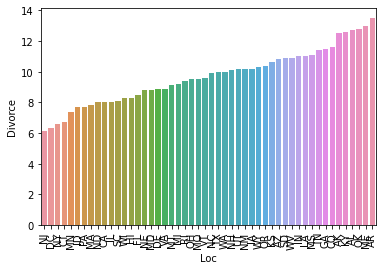

In [21]:
#sort the dataframe
pd_df = df_waffles.sort_values(['Divorce']).reset_index(drop=True)

#plot by state
sns.barplot(data=pd_df, x="Loc",y="Divorce")
plt.xticks(rotation=90)

### Do whaffle houses cause divorce?

In [22]:
#correlation
df_waffles.WaffleHouses.corr(df_waffles.Divorce)

0.25447536233295187

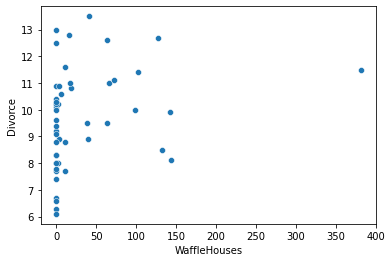

In [23]:
#scatter plot
sns.scatterplot(data=df_waffles, x="WaffleHouses", y="Divorce" )


Data wrangling

In [24]:
#split these data into training and testing datasets
df_train, df_test = train_test_split(df_waffles, test_size=0.20, random_state=34)

# Build a model

Can we predict divorce rates based on:
1. population
2. marage rates (more mariage more divorce)
3. Median age at marriage
4. Number of waffle houses

In [25]:
import statsmodels.api as sm #for running regression!
import statsmodels.formula.api as smf

#Build the model
linear_reg_model = smf.ols(formula='Divorce ~ WaffleHouses + Population + Marriage', data=df_train)

#Use the data to fit the model (i.e., find the best intercept and slope parameters)
linear_reg_results = linear_reg_model.fit()

#summary
print(linear_reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:                Divorce   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     4.391
Date:                Thu, 05 Aug 2021   Prob (F-statistic):            0.00986
Time:                        20:34:18   Log-Likelihood:                -71.332
No. Observations:                  40   AIC:                             150.7
Df Residuals:                      36   BIC:                             157.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.5888      1.391      5.458   

### Fit the model again, this time add the South variable.

In [26]:
#Build the model
linear_reg_model_South = smf.ols(formula='Divorce ~ WaffleHouses + Population + Marriage + South', data=df_train)

#Use the data to fit the model (i.e., find the best intercept and slope parameters)
linear_reg_model_South = linear_reg_model_South.fit()

#summary
print(linear_reg_model_South.summary())

                            OLS Regression Results                            
Dep. Variable:                Divorce   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     3.733
Date:                Thu, 05 Aug 2021   Prob (F-statistic):             0.0124
Time:                        20:34:18   Log-Likelihood:                -70.463
No. Observations:                  40   AIC:                             150.9
Df Residuals:                      35   BIC:                             159.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.5874      1.380      5.498   

## Let's see what feature importance suggests

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

#split data into predictors (X) and target (y)
X = df_waffles[['WaffleHouses', 'Population', 'Marriage', 'South']]
y = df_waffles['Divorce']

#split these data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#fit linear regression
LR1 = LinearRegression()
LR1.fit(X_train, y_train)

#prediction error
mean_squared_error(LR1.predict(X_test), y_test)

#model interpretation
rel_impo = permutation_importance(LR1, X_test, y_test,n_repeats=30,random_state=0)
pd.DataFrame({"feature":X_test.columns,"importance":rel_impo.importances_mean, "sd":rel_impo.importances_std})

,feature,importance,sd
0,WaffleHouses,0.045821,0.041468
1,Population,0.075875,0.062692
2,Marriage,0.055362,0.263903
3,South,0.196006,0.108203


## Let's see what feature selection suggests

In [28]:
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

#split data into predictors (X) and target (y)
X = df_waffles.drop(['Divorce','Unnamed: 0','Location','Loc'], axis=1)
y = df_waffles['Divorce']

#split these data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#build a linear regression (full model)
LR1 = LinearRegression()

#fit linear regression
LR1.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
#min number of variables/features
min_features_to_select = 1

#build the feature selection algorithm
rfecv = RFECV(estimator=LR1, step=1, cv=3,scoring='neg_mean_squared_error', min_features_to_select=min_features_to_select)

#fit the algorithm to the data
rfecv.fit(X_train, y_train)

RFECV(cv=3,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

Optimal number of features : 6


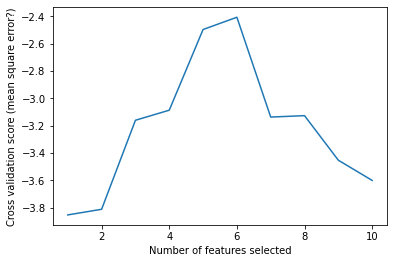

In [30]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mean square error?)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [31]:
rfecv.support_

array([False,  True,  True,  True,  True, False,  True, False, False,
        True])

In [36]:
X_train_reduced = X_train.iloc[:,rfecv.support_]

X_train_reduced.head(3)

,MedianAgeMarriage,Marriage,Marriage.SE,Divorce.SE,South,PropSlaves1860
29,27.7,14.8,0.59,0.46,0,0.000027
17,24.8,22.2,1.11,0.75,1,0.000000
34,26.3,16.9,0.61,0.45,0,0.000000


In [33]:
#get the slopes!
rfecv.estimator_.coef_

array([-0.71790402,  0.18299151, -3.12923238,  5.22113653,  0.4000835 ,
        1.40707742])

### <font color='lightblue'>Statistical confounds</font>

> Statistical confounds make it hard to determine the causal nature of the patterns we find in ML model results. We need to be careful about how we explain how a model makes predictions and the causal nature of those patterns.

> In the case of the whaffle houses and divorce rates, there are just more waffle houses in southern states.  

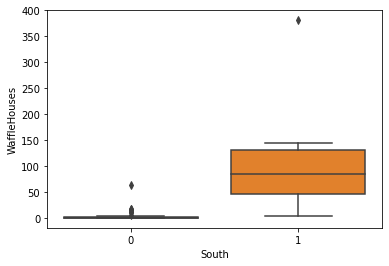

In [37]:
sns.boxplot(data=df_waffles, x="South", y="WaffleHouses")

### <font color='lightblue'>Bonus</font>

Redo the exercise above this time using a more black box approach, e.g., Random Forest!

In [38]:
from sklearn.model_selection import train_test_split

#split data into predictors (X) and target (y)
X = df_waffles[['Population','Marriage','WaffleHouses']]
y = df_waffles['Divorce']

#split these data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Find optimal hyperparameters

In [39]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': list(range(1, 10,2)),
              'n_estimators':list(range(50,200,50)),
              'max_samples':[0.5,0.7,0.9,0.99]}

randForest = RandomForestRegressor()
grid_search = GridSearchCV(randForest, parameters, cv=5, n_jobs=1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

sorted(grid_search.cv_results_.keys())
print(grid_search.best_params_)




{'max_depth': 5, 'max_samples': 0.99, 'n_estimators': 100}


Build the model with the optimal hyperparameters

In [40]:
#1. build the model
RFR = RandomForestRegressor(max_depth=5,n_estimators=50,max_samples=0.5)

#2. fit the model to the data
RFR.fit(X_train, y_train)

#3. make predictions using the model
y_pred = RFR.predict(X_test)

How well did the model perform

In [41]:
#how well does it predict
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test,y_pred)

2.861558440608589

Explain how the model is making these predictions?

In [44]:
#What is important for prediction?
from sklearn.inspection import permutation_importance

#estimate permutation importance on the test data
perm_impo = permutation_importance(RFR, X_test, y_test,scoring='neg_mean_squared_error',n_repeats=30)

#create a dataframe with the values
df_imp = pd.DataFrame({"feature":X_test.columns,"importance":perm_impo.importances_mean, "sd":perm_impo.importances_std})
sorted(sk.metrics.SCORERS.keys())

#take a look
df_imp

,feature,importance,sd
0,Population,0.358426,0.292075
1,Marriage,1.539061,0.902035
2,WaffleHouses,0.878724,0.643748


(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

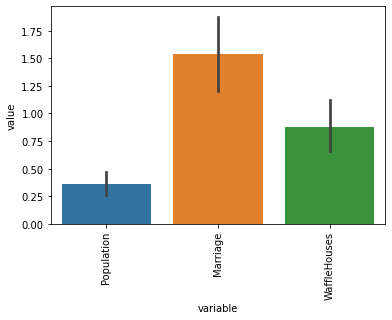

In [45]:
#plot the importance values
df_imp_all = pd.DataFrame(perm_impo.importances.transpose())
df_imp_all.columns = X_test.columns
df_imp_all_long = pd.melt(df_imp_all)
sns.barplot(data=df_imp_all_long, x="variable",y="value", ci=95)
plt.xticks(rotation=90) 


What does the model think divorce rates will change when we vary wafflehouses?

array([ 9.828     ,  9.828     , 10.95209127, 11.50665238, 11.50865238,
       11.50865238, 11.50865238, 11.50865238, 11.50865238, 11.50865238,
       11.50865238, 11.50865238, 11.50865238, 11.50865238, 11.50865238,
       11.50865238, 11.50865238, 11.50865238, 11.50865238, 11.50865238])

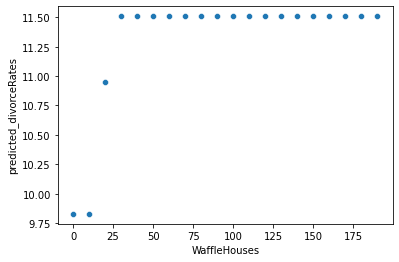

In [47]:
#1. Create a dataframe
df_question = pd.DataFrame({'Population':X_train.Population.mean(),
                            'WaffleHouses':list(range(0,200,10)),
                            'Marriage':X_train.Marriage.mean(),
                            })
                            

#2. Use the model to make predictions
question_pred =  RFR.predict(df_question)

#3. add a column to the df_question
df_question['predicted_divorceRates'] = question_pred

#4. plot the predictions
sns.scatterplot(data=df_question, x='WaffleHouses',y='predicted_divorceRates')
question_pred

In my case, the random forest model has found a positive association between wafflehouses and divorce rates!

### Repeat the analysis but this time add in the variable 'South'


Data wrangling

In [48]:
#split data into predictors (X) and target (y)
X = df_waffles[['Population','Marriage','WaffleHouses','South']]
y = df_waffles['Divorce']


#split these data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Build the model

In [49]:
RFR2 = RandomForestRegressor(max_depth=5,n_estimators=50,max_samples=0.5)
RFR2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=0.5, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Make predictions 

In [50]:
mean_squared_error(RFR2.predict(X_test), y_test)

2.3490485825328804

In [51]:
rel_impo2 = permutation_importance(RFR2, X_test, y_test,n_repeats=30,random_state=0)

pd.DataFrame({"feature":X_test.columns,"importance":rel_impo2.importances_mean, "sd":rel_impo2.importances_std})

,feature,importance,sd
0,Population,-0.014684,0.099183
1,Marriage,0.431683,0.246602
2,WaffleHouses,-0.122132,0.270624
3,South,-0.066082,0.031657


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

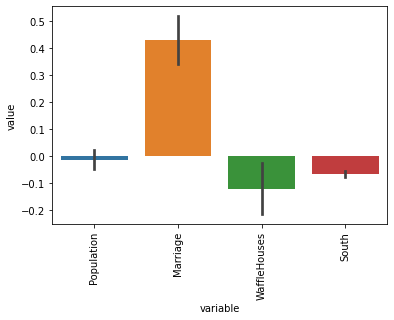

In [52]:
df_imp_all = pd.DataFrame(rel_impo2.importances.transpose())
df_imp_all.columns = X_test.columns
df_imp_all_long = pd.melt(df_imp_all)
sns.barplot(data=df_imp_all_long, x="variable",y="value", ci=95)
plt.xticks(rotation=90)


What does the model think divorce rates will change when we vary wafflehouses?

array([10.04433333, 10.04433333, 10.68667857, 11.44525   , 11.44925   ,
       11.44925   , 11.44925   , 11.44925   , 11.44925   , 11.44925   ,
       11.44925   , 11.44925   , 11.44925   , 11.44925   , 11.44925   ,
       11.44925   , 11.44925   , 11.44925   , 11.44925   , 11.44925   ])

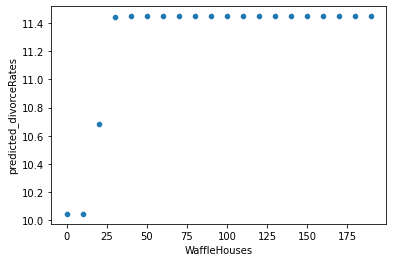

In [53]:
#1. Create a dataframe
df_question = pd.DataFrame({'Population':X_train.Population.mean(),
                            'WaffleHouses':list(range(0,200,10)),
                            'Marriage':X_train.Marriage.mean(),
                            'South':1
                            })
                            

#2. Use the model to make predictions
question_pred =  RFR2.predict(df_question)

#3. add a column to the df_question
df_question['predicted_divorceRates'] = question_pred

#4. plot the predictions
sns.scatterplot(data=df_question, x='WaffleHouses',y='predicted_divorceRates')
question_pred

In this case, the random forest model has still found a positive association between wafflehouses and divorce rates!